In [2]:
import parcels
import xarray as xr
from datetime import timedelta, datetime
import os
import json

import random
import numpy as np
import time

import matplotlib.pyplot as plt
import pandas as pd

mitgcm_results_path = '/storage/alplakes_test/ARTFUL_project/01_2023-09-12/geneva_artful_01.nc'
date_ref = np.datetime64('2023-08-31 00:00:00')
date_end_seeding = np.datetime64('2023-09-12 12:00:00')

period_seeding = np.timedelta64(10, 'D')
freq_seeding = np.timedelta64(1, 'h')

date_start_seeding = date_end_seeding - period_seeding

### Parameters

In [3]:
mitgcm_results_path = '/storage/alplakes_test/ARTFUL_project/03_2024-05-01/geneva_artful_03.nc'
date_end_seeding = np.datetime64('2024-05-01 12:00:00')

output_file_path = "02_output/artful_03.zarr"

period_seeding = np.timedelta64(10, 'D')
freq_seeding = np.timedelta64(1, 'h')

date_start_seeding = date_end_seeding - period_seeding

## Create velocity fields from MITgcm

In [4]:
xr_mitgcm = xr.open_dataset(mitgcm_results_path)
date_ref = xr_mitgcm.time.values[0]

In [13]:
variables = {"U": "UVEL", "V": "VVEL", "W": "WVEL"}
dimensions = {
    "U": {
        "lon": "XG",
        "lat": "YG",
        "depth": "Z",
        "time": "time",
    },
    "V": {
        "lon": "XG",
        "lat": "YG",
        "depth": "Z",
        "time": "time",
    },
    "W": {
        "lon": "XG",
        "lat": "YG",
        "depth": "Z",
        "time": "time",
    },
}
fieldset = parcels.FieldSet.from_mitgcm(
    filenames=[mitgcm_results_path], 
    variables=variables, 
    dimensions=dimensions, 
    allow_time_extrapolation=False,
    mesh='flat') # mesh='flat' if longitudes and latitudes are given in meters, rather than degrees

In [14]:
x = fieldset.U.grid.lon
y = fieldset.U.grid.lat

cell_areas = parcels.Field(
    name="cell_areas", data=fieldset.U.cell_areas(), lon=x, lat=y
)
fieldset.add_field(cell_areas)

fieldset.add_constant("Cs", 0.1)

## Create particle set

Here we create particles randomly seeded within a defined circle.

In [15]:
def RandomPointInCircle(R,xc,yc):
    r = R*random.random()
    theta = 2*np.pi*random.random()
    
    return xc+r*np.cos(theta),yc+r*np.sin(theta)

In [16]:
def RandomPointInRectangle(xmin, xmax, ymin, ymax):
    return xmin+(xmax-xmin)*random.random(), ymin+(ymax-ymin)*random.random()

In [17]:
n_part_per_seeding = 2000
n_part = int(n_part_per_seeding * period_seeding / freq_seeding) # total number of particles at the end
print('Total number of particles: ' + str(n_part))
print('Date ref: ' + str(date_ref))
print('Date start seeding: ' + str(date_start_seeding))
print('Date end seeding: ' + str(date_start_seeding + int(period_seeding / freq_seeding) * freq_seeding))

depth_min = 1 # minimum release depth
depth_max = 3 # maximum release depth
(x_c,y_c) = (44275, 21375) # center of seeding point in MITgcm coordinates
r_seeding = 50 # the radius around the center in m

zi_particles = np.array([-random.uniform(depth_min, depth_max) for i in range(n_part)])
xi_particles = x_c*np.ones(n_part)
yi_particles = y_c*np.ones(n_part)


timei_particles = np.zeros(n_part)
for i in range(int(period_seeding / freq_seeding)):
    seeding_date = date_start_seeding + i * freq_seeding
    timei_particles[i * n_part_per_seeding : (i+1) * n_part_per_seeding] = (seeding_date - date_ref)/ np.timedelta64(1, 's')

for i in range(n_part):
    (xd,yd) = RandomPointInCircle(r_seeding,x_c,y_c)
    xi_particles[i] = xd
    yi_particles[i] = yd

Total number of particles: 480000
Date ref: 2024-04-16T07:00:00.000000000
Date start seeding: 2024-04-21T12:00:00
Date end seeding: 2024-05-01T12:00:00


In [18]:
pset = parcels.ParticleSet.from_list(
    fieldset=fieldset,  # the fields on which the particles are advected
    pclass=parcels.JITParticle,  # the type of particles (JITParticle or ScipyParticle)
    lon=xi_particles,  # a vector of release longitudes
    lat=yi_particles,  # a vector of release latitudes
    depth=zi_particles,
    time=timei_particles
)

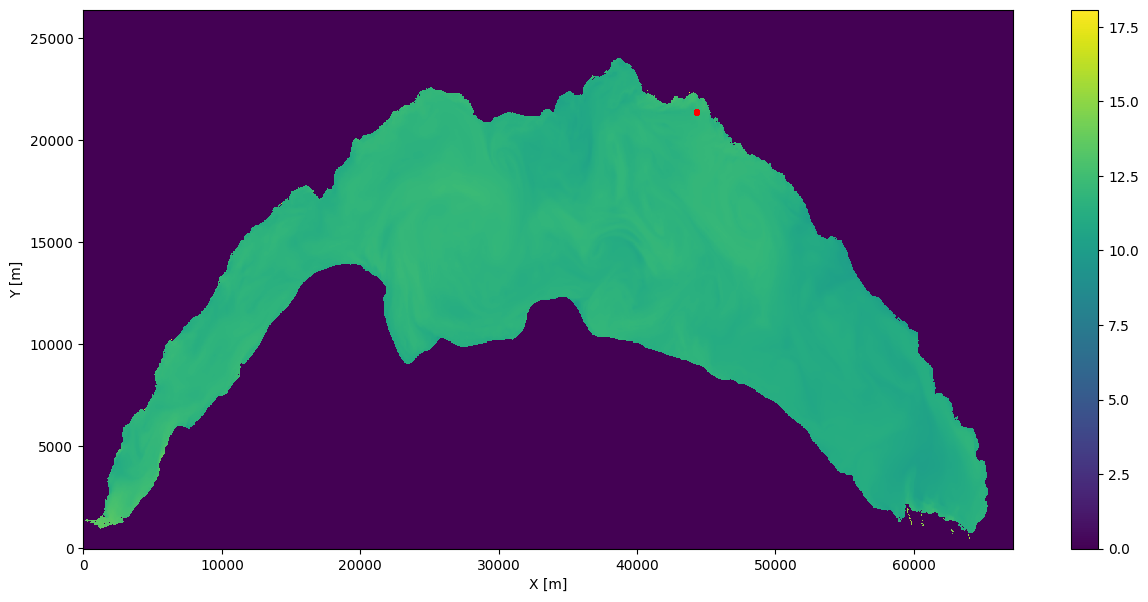

In [19]:
plt.figure(figsize=(15,7))
plt.pcolormesh(fieldset.U.grid.lon, fieldset.U.grid.lat, xr_mitgcm['THETA'].isel(Z=0, time= -1).values)
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.colorbar()

plt.scatter(pset.lon[0:n_part_per_seeding], pset.lat[0:n_part_per_seeding], s=3, c='r')
#plt.xlim(left=35000, right=50000)
#plt.ylim(bottom=15000)
plt.show()

## Create a new kernel for Smagorinsky diffusion method

In [21]:
def smagdiff(particle, fieldset, time):
    dx = 0.01
    # gradients are computed by using a local central difference.
    updx, vpdx = fieldset.UV[time, particle.depth, particle.lat, particle.lon + dx]
    umdx, vmdx = fieldset.UV[time, particle.depth, particle.lat, particle.lon - dx]
    updy, vpdy = fieldset.UV[time, particle.depth, particle.lat + dx, particle.lon]
    umdy, vmdy = fieldset.UV[time, particle.depth, particle.lat - dx, particle.lon]

    dudx = (updx - umdx) / (2 * dx)
    dudy = (updy - umdy) / (2 * dx)

    dvdx = (vpdx - vmdx) / (2 * dx)
    dvdy = (vpdy - vmdy) / (2 * dx)

    A = fieldset.cell_areas[time, 0, particle.lat, particle.lon]
    sq_deg_to_sq_m = (1852 * 60) ** 2 * math.cos(particle.lat * math.pi / 180)
    A = A / sq_deg_to_sq_m
    Kh = fieldset.Cs * A * math.sqrt(dudx**2 + 0.5 * (dudy + dvdx) ** 2 + dvdy**2)

    dlat = parcels.ParcelsRandom.normalvariate(0.0, 1.0) * math.sqrt(
        2 * math.fabs(particle.dt) * Kh
    )
    dlon = parcels.ParcelsRandom.normalvariate(0.0, 1.0) * math.sqrt(
        2 * math.fabs(particle.dt) * Kh
    )

    particle_dlat += dlat
    particle_dlon += dlon

## Set output parameters

In [22]:
output_file = pset.ParticleFile(
    name=output_file_path,  # the file name
    outputdt=timedelta(hours=1),  # the time step of the outputs
)

In [23]:
period_seeding.astype('timedelta64[D]').astype(int)

np.int64(10)

## Run simulation

In [ ]:
start_clock = time.time()
pset.execute(
    [parcels.AdvectionRK4, smagdiff],  # the kernel (which defines how particles move)
    runtime=timedelta(days=int(period_seeding.astype('timedelta64[D]').astype(int)), hours=4),  # the total length of the run
    dt=timedelta(minutes=1),  # the timestep of the kernel
    output_file=output_file,
)
end_clock = time.time()
print(f'Done. Operation took {end_clock - start_clock}s.')

INFO: Output files are stored in 02_output/artful_03.zarr.
  4%|████▌                                                                                                                      | 32400.0/878400.0 [00:39<15:53, 887.71it/s]